In [1]:
## return a random sample from a normal (Gaussian) distribution
function rand_normal(mean, stdev)
    if stdev <= 0.0
        error("standard deviation must be positive")
    end
    u1 = rand()
    u2 = rand()
    r = sqrt( -2.0*log(u1) )
    theta = 2.0*pi*u2
    mean + stdev*r*sin(theta)
end


## return a random sample from a gamma distribution
function rand_gamma(shape, scale)
    if shape <= 0.0
        error("Shape parameter must be positive")
    end
    if scale <= 0.0
        error("Scale parameter must be positive")
    end
    
    ## Implementation based on "A Simple Method for Generating Gamma Variables"
    ## by George Marsaglia and Wai Wan Tsang.  
    ## ACM Transactions on Mathematical Software
    ## Vol 26, No 3, September 2000, pages 363-372.

    if shape >= 1.0
        d = shape - 1.0/3.0
        c = 1.0/sqrt(9.0*d)
        while true
            x = rand_normal(0, 1)
            v = 1.0 + c*x
            while v <= 0.0
                x = rand_normal(0, 1)
                v = 1.0 + c*x
            end
            v = v*v*v
            u = rand()
            xsq = x*x
            if u < 1.0 -.0331*xsq*xsq || log(u) < 0.5*xsq + d*(1.0 - v + log(v))
                return scale*d*v
            end
        end
    else
        g = rand_gamma(shape+1.0, 1.0)
        w = rand()
        return scale*g*pow(w, 1.0/shape)
    end
end

function gamrnd(A,B,m,n)
    gam_nums = zeros(m,n)
    for i = 1:m
        for j = 1:n
            gam_nums[i,j] = rand_gamma(A,B)
        end
    end
    gam_nums
end



gamrnd (generic function with 1 method)

In [2]:
stime = 1000 # simulate the neuron for 1000ms
dt = 0.5 # timestep of 0.5ms
n = 1000 # number of independent neurons
n_syn = 100
# Izekevich constants
inh = (rand(n,1) .< 0.2)
exc = !inh
d = 8.0 * exc + 2.0 * inh
a = 0.02 * exc + 0.1 * inh
c = -65.0
b = 0.2
#Array of timesteps
T = round(Int,(ceil(stime/dt))) 
#Initialize membrane potential variables of Izekevich model
v = zeros(n,T)   # membrane potential for n rows and T timesteps
u = zeros(n,T)
dv = zeros(n,T)   # membrane potential for n rows and T timesteps
du = zeros(n,T)

v[:,1] = -70.0
u[:,1] = -14.0

#Incoming synapses
n_in = n_syn # number of input synapses
rate = 2*1e-3 # poison rate of input spikes (2hz = 2e-3 spikes/ms)
tau_g = 10.0  # decay constant for the PSconductance (filter)
g_in = zeros(n_in,1) # conductances
E_in = zeros(n_in,1) # driving potential; 0 for exctitatory 
w_in = 0.07 * ones(n, n_in) # weights of the synapses for all neurons
w_in[rand(n,n_in) .> 0.1] = 0.0

g = zeros(n,1) # synapses from recurrent neurons
E = zeros(n,1)
E[inh] = -85.0
W = zeros(n,n)
idx =  find(rand(n,n) .< 0.1)
W[idx] = gamrnd(2,3e-3, length(idx),1)
W[exc,inh] = 2 * W[exc,inh]
W = sparse(W)





#spikes = zeros(T,1)
#gMon = zeros(T,1)

1000x1000 sparse matrix with 99817 Float64 entries:
	[17  ,    1]  =  0.00938948
	[18  ,    1]  =  0.00609494
	[21  ,    1]  =  0.00406954
	[22  ,    1]  =  0.00714531
	[24  ,    1]  =  0.00929401
	[39  ,    1]  =  0.0227824
	[42  ,    1]  =  0.00468532
	[68  ,    1]  =  0.00446074
	[71  ,    1]  =  0.00811054
	[76  ,    1]  =  0.00710811
	⋮
	[920 , 1000]  =  0.00340987
	[922 , 1000]  =  0.0067526
	[929 , 1000]  =  0.00761373
	[936 , 1000]  =  0.000564147
	[938 , 1000]  =  0.00939955
	[939 , 1000]  =  0.00809104
	[947 , 1000]  =  0.00197011
	[948 , 1000]  =  0.00517454
	[963 , 1000]  =  0.00434639
	[976 , 1000]  =  0.00992586
	[991 , 1000]  =  0.00175268

In [16]:
tic();
#Iapp = []
#dv = []
fired = false

for t = 1:T-1    
    #generate poison spikes
    if (t*dt > 200.0) && (t*dt < 700.0)
        p = float(rand(n_in,1) .< rate*dt)
    else 
        p = 0.0; #zeros(n_in,1);
    end
 
    # Normal synapses
    g_in = g_in + p   # update condutance for each spike
    Iapp = (w_in * (g_in .* E_in)) - ((w_in * g_in).*v[:,t])
    #Iapp = Iapp[1,1] # Iapp is 2x2 array with one element != float !!
     g_in = (1.0 - (dt/tau_g)) *g_in
    
    #recurrent synapses
    g = g + float(fired)
    Isyn = W * (g.*E) - (W*g) .* v[:,t]
    Iapp = Iapp + Isyn
    g = (1.0 - (dt/tau_g))*g
    
     dv = (v[:,t].*(0.04*v[:,t] + 5.0)) + 140.0 - u[:,t]
     v[:,t+1] = v[:,t] + (dv + Iapp)*dt;
     du = a.*(b * v[:,t] - u[:,t]);
     u[:,t+1] = u[:,t] + dt*du;
     
    fired = (v[:,t] .>= 35.0)
    v[fired, t] = 35.0
    v[fired, t+1] = c
    u[fired,t+1] = u[fired,t] + d[fired]; 
  
end
toc();

elapsed time: 1.632076234 seconds


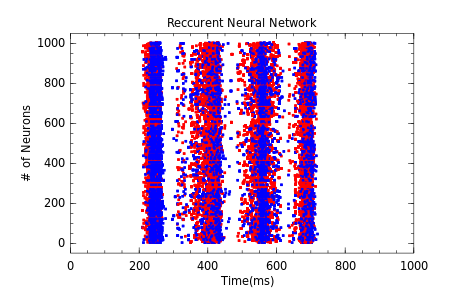

In [18]:
spiks = sparse(int(v.==35.0))
spiks[inh,:] = 2*spiks[inh,:]
#(X, Y) = meshgrid(1:n,1:T)
(espk,etime) = findn(spiks.==1) ;
(ispk,itime) = findn(spiks.==2) ;

using Winston
plot(etime*dt,espk, "r.")
hold(true)
xlim(0,stime)
plot(itime*dt,ispk,"b.")
title("Reccurent Neural Network")
xlabel("Time(ms)")
ylabel("# of Neurons")


